# Transmission matrix 
## acquisition, calculation and phase conjugation

### Phase shift interferometry (4-step)
this method can be used to measure the complext field of an interference pattern and it actually removes the mean amplitude term from the equation.


The light intensity measured on the camera is:

$$I_{\rm{camera}} = |e^{ia}E_{\rm{ref}}+E_{\rm{(x,y)}}|^2, $$

$E_{\rm{ref}}$ is the non-modulated part of the beam which acts as a local oscillator, 

$E_{\rm{(x, y)}}$ is the SML-modulated part of the beam,

$a$ is the phase which in this case will take four values: $0, \pi, \pi/2, 3\pi/2$. Therefore four each SLM pattern, four measurements will be carried out. 

The complex field is found to be:

$$E_{\rm{(x,y)}} =\frac{1}{E_{\rm{ref}}} \Bigg( \frac{I_0 - I_\pi}{4} + i \frac{I_{3\pi/2} - I_{\pi/2}}{4}\Bigg)$$



 On the pixel $j$ of the camera one gets the following field:
 
$$ \frac{I_0^j - I_\pi^j}{4} + i \frac{I_{3\pi/2}^j - I_{\pi/2}^j}{4} = \overline{s}^j \sum_i h^{ij} E_{\rm{in}}^i, $$

where

i: pixel on the slm

j: pixel on the camera

And the observed transmission matrix is:

$$ h_{ij}^{\rm{obs}} =  \frac{I_0^j - I_\pi^j}{4} + i \frac{I_{3\pi/2}^j - I_{\pi/2}^j}{4}. $$

### Effect of referecence beam and normalization
The observed transmission matrix has is affected by the reference beam. It has been shown that for a homogenous laser beam at the input of the SLM, this effect is statit at the output pixels; it is the same at a given pixel (see Popoff PhD). Therefore this effect can be reduced on the observed matrix by normalizing the latter by the standard deviation on a camera pixel, calculated for all the input vectors:

$$h_{ij}^{\rm{filtered}} = \frac{h_{ij}^{\rm{obs}}}{\sqrt{\langle|h_{ij}^{\rm{obs}}|^2\rangle}_i}$$, 

where $\sqrt{\langle|h_{ij}^{\rm{obs}}|^2\rangle}_i$ is the standard deviation. 

### Basis change
The filtered transmission matrix $h_{ij}^{\rm{filtered}}$ gives the relationship between and hadamard vector and the camera pixels. What we need in the end is a transmission matrix that gives the relationship between a SLM pixel and the camera pixels. 

For this, a basis change (from the hadamard basis to the canonical one) is needed to find the real transmission matrix:

$$H^{\rm{can}} = H_{\rm{ij}}^{\rm{had}} \times \mathcal{H}, $$

with $\mathcal{H}$ the corresponding Hadamard matrix. 

#### import libraries

In [1]:
from slmOptim.optimization import transmission_matrix
from slmOptim.optimization import phase_conjugation
from slmOptim.optimization.init_experiment import InitExperiment

from slmOptim.zeluxPy import helper_functions as cam

from slmOptim.patternSLM import patterns as pt
from slmOptim.patternSLM.helper_functions import check

from slmPy import slmpy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pickle



#### set experiment parameters

In [215]:
# SLM-hadamard parameters

# SLM resolution 
resX, resY = (800, 600)

# the number of controlled segments on the SLM num_in ** 2
num_in = 32

# size of macropixels on slm 2 ** slm_macropix
slm_macropixel = 4

# Define observation window on camera
roi_size = 100
off = (0, 0)

roi = cam.set_roi(roi_size, off)
print(roi)

# Define camera macropixel, this is defined by the measured speckel grain
bins = 4

# Define camera acquisition parameters
exposure_time = 200
gain = 1
timeout= 100

# path to save raw data
path = '/home/optomeca/Documents/measurements'

(670, 490, 770, 590)


In [3]:
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()



Connected to 10.42.0.234 on 9999


In [5]:
slm_raspPi = init.init_slm()

Connected to 10.42.0.234 on 9999


In [ ]:
roi_size = 1100
off = (0, 0)
bins = 1
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()
print(frame.shape)
init.close_cam()

In [216]:
init.close_cam()
roi_size = 100
off = (0, 0)
bins = 4
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()


#### just do some quick checks

Data transmitted


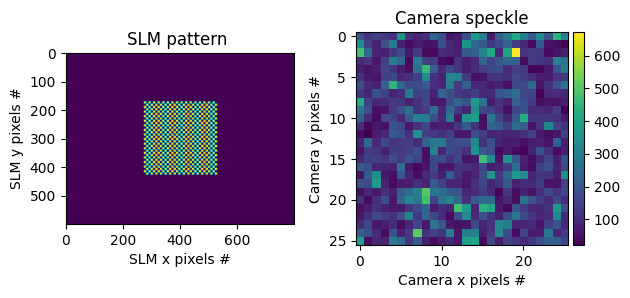

In [219]:
pattern, frame = check(slm_raspPi, camera, 
                       num_in, (1, 1), slm_macropixel)

Data transmitted


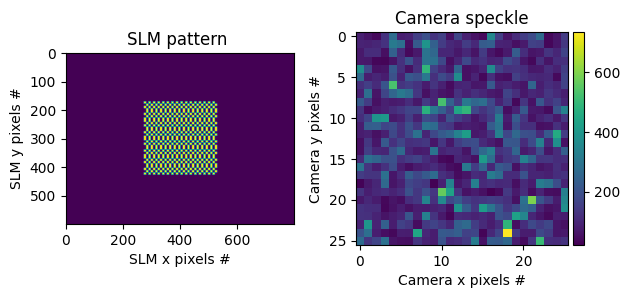

In [218]:
pattern, frame = check(slm_raspPi, camera, 
                       num_in, (5, 1), slm_macropixel)

### 1. Perform TM measurement

In [220]:
# instantiate tm
tm_raw = transmission_matrix.measTM(slm_raspPi,
                                     camera,
                                     num_in=num_in, 
                                     slm_macropixel_size=slm_macropixel, 
                                     save_path=path,
                                     remote=True)

time_delay = 0.1
patterns, frames = tm_raw.get2(time_delay)

Uploading Hadamard patterns:   0%|          | 0/1024 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

In [ ]:
# save raw data if you want
tm_raw.save()

### 2. Calculate TM

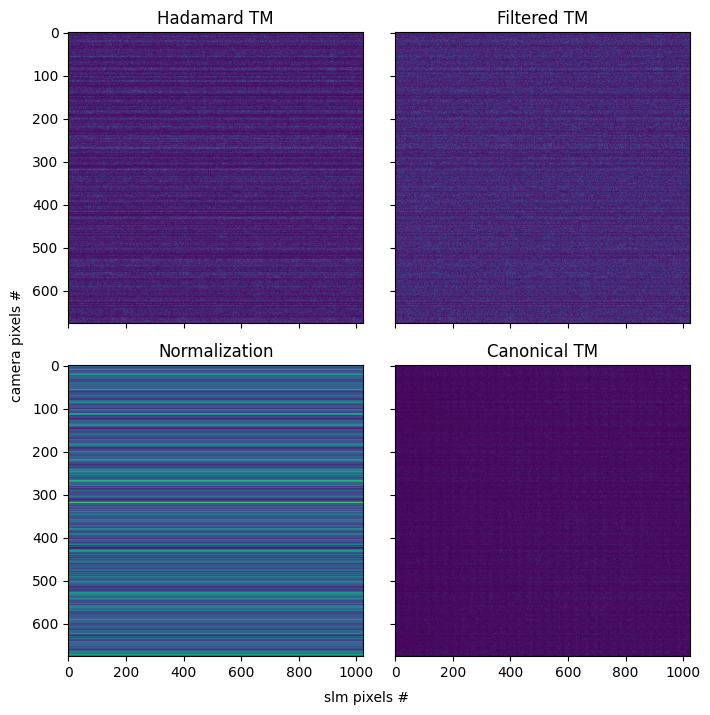

In [221]:
# filepath = '/home/optomeca/Documents/measurements/20230915-1354_tm_raw_data_ROI(770, 590, 867, 687)_Bins4_Order4_Mag5.pkl'

# with open(filepath, 'rb') as fp:
#     data = pickle.load(fp)

data = frames
# data = data[1]

tr = transmission_matrix.calcTM(data)
tm_had, norm, tm_fil, tm = tr.calc_plot_tm()

### 3. Phase conjugation -  Focusing

In [222]:

init.close_cam()

In [223]:
bins=1
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()

In [262]:
# define target
target_shape = (int(tm.shape[0] ** 0.5), int(tm.shape[0] ** 0.5))
tgt = phase_conjugation.Target(target_shape)
target_frame1 = tgt.square((1, 1), offset_x=0, offset_y=0, intensity=0.1)

target_frame = target_frame1

# phase conjugation - create mask
msk = phase_conjugation.InverseLight(target_frame, tm, slm_macropixel=slm_macropixel)
phase_mask = msk.inverse_prop()

# merge phase mask into an slm pattern
slm_patterns = pt.Pattern(resX, resY)
patternSLM = pt.Pattern(resX, resY)
focusing_mask = patternSLM.add_subpattern(phase_mask, gray = 100)

# apply mask
slm_raspPi.sendArray(focusing_mask)

Data transmitted


1

In [263]:
# get frame
frame = camera.get_pending_frame_or_null()
frame_focus = np.copy(frame.image_buffer)

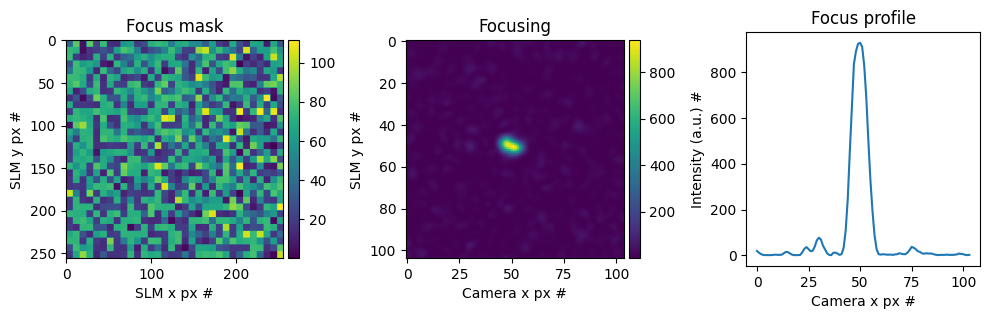

In [264]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
mask = axs[0].imshow(phase_mask)
axs[0].set_title("Focus mask")
axs[0].set_xlabel("SLM x px #")
axs[0].set_ylabel("SLM y px #")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mask, cax=cax)   

frame = axs[1].imshow(frame_focus)
axs[1].set_title("Focusing")
axs[1].set_xlabel("Camera x px #")
axs[1].set_ylabel("SLM y px #")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(frame, cax=cax)   

axs[2].plot(frame_focus[50])
axs[2].set_box_aspect(1)
axs[2].set_title("Focus profile")
axs[2].set_xlabel("Camera x px #")
axs[2].set_ylabel("Intensity (a.u.) #")

fig.tight_layout()

In [265]:
init.close_cam()
slm_raspPi.close()

In [20]:
patSLM = pt.Pattern(resX, resY)
mirror = patSLM.mirror()

hadamard_basis = patSLM._get_hadamard_basis(16)


vector = hadamard_basis[60]
vector = patSLM._enlarge_pattern(vector, 5)
vector = patSLM.add_subpattern(vector)

slm_raspPi.sendArray(vector)

Data transmitted


1

In [ ]:
# slm_raspPi.sendArray(focusing_mask)
slm_raspPi.sendArray(mirror)

In [ ]:
slm_raspPi.close()

In [ ]:
slm_raspPi = init.init_slm()

In [ ]:
plt.imshow(frame_focus)


In [ ]:
roi_size = 500
# off = (-80, 0)

init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
init.close_cam()

In [ ]:
init.close_cam()